In [1]:
from tensorflow.keras.applications import vgg16
from tensorflow import keras
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.python.framework import ops
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
from tensorflow import keras
import sys
import cv2
from tensorflow.keras.models import load_model
import json
import dlib
from PIL import Image
tf.compat.v1.disable_eager_execution()


In [2]:
from keras.models import load_model
import os
import sys
import pandas as pd
from PIL import Image
import numpy as np
sys.path.insert(1, '../src')

import preprocess_image
import importlib
importlib.reload(preprocess_image)

import matplotlib.pyplot as plt

In [5]:
# with open("./config/parameters.json") as f:
#     data = json.load(f)
# f.close()

# model_param = data["model_param"]
# lr, epochs, batch_size, mapping_path, save_path, log_path, biased_save_path = model_param.values()

# with open(mapping_path) as f:
#     mapping = json.load(f)
# f.close()

In [3]:
model_param

{'lr': 0.0008,
 'epochs': 300,
 'batch_size': 128,
 'mapping_path': './mapping/race.json',
 'save_path': './models/race/race_v6.hdf5',
 'log_path': './logs/race/race_v6.csv'}

In [4]:
mapping

{'Black': 0,
 'East Asian': 1,
 'Indian': 2,
 'Latino_Hispanic': 3,
 'Middle Eastern': 4,
 'Southeast Asian': 5,
 'White': 6}

In [19]:
def detect_face(image_path, im_size = 224, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('./dlib_mod/mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('./dlib_mod/shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height

    img = dlib.load_rgb_image(image_path)
    old_height, old_width, _ = img.shape
    old_height, old_width, _ = img.shape

    if old_width > old_height:
        new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
    else:
        new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
    img = dlib.resize_image(img, rows=new_height, cols=new_width)
    dets = cnn_face_detector(img, 1)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found in '{}'".format(image_path))
        return
    elif num_faces > 1:
        print("Multiple face in '{}'. A random face will be returned".format(image_path))
    faces = dlib.full_object_detections()
    for detection in dets:
        rect = detection.rect
        faces.append(sp(img, rect))
    image = dlib.get_face_chips(img, faces, size=size, padding = padding)[0]

    image = Image.fromarray(image, 'RGB')
    image = image.resize((im_size, im_size))

    #image = np.array(image) / 255.0
    #ori_img = np.array(image)
    processed_img = resnet_v2.preprocess_input(np.array(image))
    processed_img = processed_img[None,:]
    return processed_img

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet_v2.preprocess_input(x)
    #x = detect_face(img_path)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_7'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = load_model(save_path)
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #if K.image_dim_ordering() == 'th':
    #    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, input_biased_model, image, category_index, biased_category_index, layer_name):
    model = input_model
    biased_model = input_biased_model
    #model = Sequential()
    #model.add(input_model)

    nb_classes = 7
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    biased_target_layer = lambda x: target_category_loss(x, biased_category_index, nb_classes)
    
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))
    
    biased_model.add(Lambda(biased_target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    #print("loss: ", loss)
    biased_loss = K.sum(biased_model.layers[-1].output)
    
    #conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output =  [l for l in model.layers if l.name == layer_name][0].output
    #print("conv_output: ", conv_output)
    biased_conv_output =  [l for l in biased_model.layers if l.name == layer_name][0].output
    
    
    grads = normalize(K.gradients(loss, conv_output)[0])
    biased_grads = normalize(K.gradients(biased_loss, biased_conv_output)[0])
    
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    biased_gradient_function = K.function([biased_model.layers[0].input], [biased_conv_output, biased_grads])
    

    output, grads_val = gradient_function([image])
    biased_output, biased_grads_val = biased_gradient_function([image])
    
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    biased_output, biased_grads_val = biased_output[0, :], biased_grads_val[0, :, :, :]
    

    weights = np.mean(grads_val, axis = (0, 1))
    biased_weights = np.mean(biased_grads_val, axis = (0, 1))
    
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)
    biased_cam = np.ones(biased_output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    for i, w in enumerate(biased_weights):
        biased_cam += w * biased_output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    biased_cam = cv2.resize(biased_cam, (224, 224))
    #print("cam1: ", cam)
    cam = np.maximum(cam, 0)
    biased_cam = np.maximum(biased_cam, 0)
    #print("cam2: ", cam)

    max_arr = np.concatenate([cam,biased_cam])
#     return np.max(cam)
    max_norm = np.max(max_arr)
#     print("cam_max: ", np.max(cam))
#     print("b_cam max: ", np.max(biased_cam))
#     return max_norm
#     heatmap = cam / np.max(cam)
    heatmap = cam / np.max(cam)
    biased_heatmap = biased_cam/ max_norm
    
    #print("heat: ", heatmap)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    biased_cam = cv2.applyColorMap(np.uint8(255*biased_heatmap), cv2.COLORMAP_JET)
    
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    biased_heatmap = cv2.applyColorMap(np.uint8(255*biased_heatmap), cv2.COLORMAP_JET)
    
    cam = np.float32(cam / 255) + np.float32(image)
    biased_cam = np.float32(biased_cam / 255) + np.float32(image)
    #heatmap = np.float32(cam / 255)
    
    cam = 255 * cam / np.max(cam)
    biased_cam = 255 * biased_cam / np.max(biased_cam)
    #heatmap = 255 * heatmap / np.max(heatmap)
    
    return np.uint8(cam), np.uint8(biased_cam), heatmap, biased_heatmap, image
    #return cam, heatmap, image

In [4]:
model = load_model(save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### NOTE

If you want to input your own image(i.e. images that are not from the FairFace), please uncomment the last line in load_image function and comment out the rest(except the first line)

* After you run the code below, it will generate two images: one for grad-cam and one for guided grad-cam. 

In [5]:
sample_img = '/teams/DSC180A_FA20_A00/a01explainableai/a01capstonegroup03/fairface_pad025/val/7.jpg'
#sample_img = "./IMG_5321.jpg"
preprocessed_input = load_image(sample_img)
predictions = model.predict(preprocessed_input)
predicted_class = np.argmax(predictions)
cam, heatmap, img = grad_cam(model, preprocessed_input, predicted_class, "conv2d_7")
cv2.imwrite("gradcam_7.jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam_7.jpg", deprocess_image(gradcam))

True

In [ ]:
#******

In [11]:
# preprocessed_input = load_image(img_path)
# predictions = race_model.predict(preprocessed_input)
# biased_preds = race_biased_model.predict(preprocessed_input)

# predicted_class = np.argmax(predictions)
# biased_class = np.argmax(biased_preds)

# grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")

cam_max:  15.540716
b_cam max:  364.7844


364.7844

In [75]:
race_biased_model = load_model("../race_biased_v1-Copy1.hdf5")
race_model = load_model("../race_t6-Copy1.hdf5") 

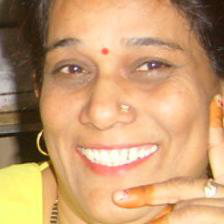

In [106]:
img_num = 97
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [107]:
#UNBIASED RACE GRAD-CAM
race_biased_model = load_model("../race_biased_v1-Copy1.hdf5")
race_model = load_model("../race_t6-Copy1.hdf5") 

preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
#cv2.imwrite("heatmap_" + str(img_num) + ".jpg", heatmap)
#cv2.imwrite("gradcam_" + str(img_num) + ".jpg", cam)
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [108]:
predicted_class, biased_class

(2, 3)

In [109]:
val_df[val_df['file'] == "val/" + str(img_num) + ".jpg"]

,file,age,gender,race,service_test
96,val/97.jpg,50-59,Female,Indian,True


In [84]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)

In [85]:
predictions

array([[0.00117577, 0.0015174 , 0.62585884, 0.2310237 , 0.10587282,
        0.00729686, 0.02725458]], dtype=float32)

In [79]:
predicted_class = np.argmax(predictions)

In [80]:
predicted_class

2

In [51]:
predictions

array([[0.        , 0.        , 0.05369131, 0.        , 0.        ,
        0.        , 0.        ]], dtype=float32)

In [ ]:
race_biased_model.summary()

In [37]:
#BIASED RACE GRAD-CAM
preprocessed_input = load_image(img_path)
predictions = race_biased_model.predict(preprocessed_input)
predicted_class = np.argmax(predictions)
cam, heatmap, img = grad_cam(race_biased_model, preprocessed_input, predicted_class, "conv2d_7")
#cv2.imwrite("biased_heatmap_" + str(img_num) + ".jpg", heatmap)
cv2.imwrite("biased_gradcam_" + str(img_num) + ".jpg", cam)

True

In [38]:
predicted_class

3

In [32]:
race_dict = {
        6: 'White', 
        0: 'Black', 
        1: 'East Asian', 
        2: 'Indian', 
        4: 'Middle Eastern',
        3: 'Latino_Hispanic',
        5: 'Southeast Asian'
}

NameError: name 'img_face' is not defined

In [ ]:
#Average Heatmaps

In [21]:
val_df = pd.read_csv("../../a01capstonegroup03/fairface_label_val.csv")
val_df.head()

,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


In [25]:
val_df[val_df['file'] == "val/" + str(img_num) + ".jpg"]

,file,age,gender,race,service_test
139,val/140.jpg,3-9,Male,Southeast Asian,False


In [104]:
val_df[val_df["race"] == "Indian"][:15]

,file,age,gender,race,service_test
12,val/13.jpg,40-49,Female,Indian,True
13,val/14.jpg,20-29,Male,Indian,True
30,val/31.jpg,3-9,Female,Indian,True
31,val/32.jpg,40-49,Female,Indian,False
39,val/40.jpg,50-59,Female,Indian,False
41,val/42.jpg,20-29,Female,Indian,False
69,val/70.jpg,20-29,Male,Indian,True
73,val/74.jpg,30-39,Female,Indian,False
75,val/76.jpg,20-29,Male,Indian,True
90,val/91.jpg,10-19,Female,Indian,True


In [11]:
val_df['race'].value_counts()

White              2085
Latino_Hispanic    1623
Black              1556
East Asian         1550
Indian             1516
Southeast Asian    1415
Middle Eastern     1209
Name: race, dtype: int64

In [15]:
def race_prediction(preprocessed_input):
    pred2 = race_model.predict(preprocessed_input)[0]
    race_dict = {
        6: 'White', 
        0: 'Black', 
        1: 'East Asian', 
        2: 'Indian', 
        4: 'Middle Eastern',
        3: 'Latino_Hispanic',
        5: 'Southeast Asian'
    }
    max_ind = list(pred2).index(max(pred2))
    return race_dict[max_ind]

In [11]:
#generate average heatmap for a specific race
from tqdm import tqdm
def generate_avg_heatmap(race, val_df):
    race_val_df = val_df[val_df["race"] == race][:20]
    heatmaps = []
    for row in tqdm(race_val_df.iterrows()):
        img_file = row[1]["file"]
        img_path = "../../a01capstonegroup03/fairface_pad025/" + img_file
        
#         orig = cv2.imread(img_path)
        #print(img_path)
        #resized = cv2.resize(orig, (224, 224))
        
        preprocessed_input = load_image(img_path)
        predictions = race_model.predict(preprocessed_input)
        predicted_class = np.argmax(predictions[0])
        
        cam, heatmap, img = grad_cam(race_model, preprocessed_input, predicted_class, "conv2d_7")
        #cv2.imwrite("gradcam_1234.jpg", cam)
#         cam = GradCAM(race_model, predicted_class)
#         heatmap = cam.compute_heatmap(img_face)
        
#         resized = cv2.resize(orig, (198, 198))
#         heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
#         (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
    
        heatmaps.append(heatmap)
        
    
    arr= np.zeros((224,224, 3),np.float)
    N = len(heatmaps)
    for im in heatmaps:
        imarr=np.array(im,dtype=np.float)
#         print(arr.shape)
#         print(imarr.shape)
        
        arr=arr+imarr/N

    # Round values in array and cast as 8-bit integer
    arr=np.array(np.round(arr),dtype=np.uint8)
    cv2.imwrite("race20_"+ race + "_heatmap.jpg", arr)
        

In [10]:
generate_avg_heatmap("White", val_df) #100 

100it [35:23, 21.24s/it]


In [13]:
generate_avg_heatmap("Black", val_df)

50it [44:44, 53.70s/it]


In [12]:
generate_avg_heatmap("Indian", val_df)

20it [02:27,  7.36s/it]
